In [76]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from pandas_ods_reader import read_ods
import pandas as pd
from scoping.models import *
import random
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

django.db.connection.close()

In [77]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")

In [78]:
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])
category_map.head()

,Broad category,Specific category,Labelled documents,Proposed Aggregation 1,Proposed Aggregation 2,Proposed Aggregation 3
0,Physical systems,01 CO2 concentration,5,-,,
1,Physical systems,02 Air or land surface temperature changes,47,-,,
2,Physical systems,03 Extreme temperature,16,-,,
3,Physical systems,04 Radiation,1,-,,
4,Physical systems,05 Changes in precipitation,55,-,,


In [79]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(seen_df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

new_rel_index = physical_index.intersection(rel_index)

(2312, 243)


In [80]:
from alterations import postfix_data
df = postfix_data(df)

In [81]:
impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1


In [82]:
specific_impacts_1 = [x for x in df.columns if "17 - " in x]
specific_impacts_1

['17 - Other rivers, lakes and soil',
 '17 - Water level',
 '17 - Evapotranspiration',
 '17 - Drought',
 '17 - Floods',
 '17 - Runoff',
 '17 - Snow',
 '17 - Permafrost',
 '17 - Sea ice',
 '17 - Glaciers',
 '17 - Distribution and range shifts (CMES)',
 '17 - Phenology (CMES)',
 '17 - Food/Agriculture',
 '17 - Corals',
 '17 - Physiology, metabolism, mortality and growth (CMES)',
 '17 - Community composition and interaction (CMES)',
 '17 - Ecosystem productivity and carbon cycle (CMES)',
 '17 - Distribution and range shifts (TES)',
 '17 - Phenology (TES)',
 '17 - Physiology, metabolism, mortality and growth (TES)',
 '17 - Community composition and interaction (TES)',
 '17 - Ecosystem productivity and carbon cycle (TES)',
 '17 - Wildfires',
 '17 - Livelihoods and wellbeing',
 '17 - Health',
 '17 - Displacement and migration']

In [83]:
specific_impacts_2 = [x for x in df.columns if "18 - " in x and df[x].sum() > 5]
specific_impacts_2

['18 - Terrestrial Water Cycle',
 '18 - Drought & Floods',
 '18 - Cryosphere',
 '18 - Coastal and marine Ecosystems',
 '18 - Food/Agriculture',
 '18 - Carbon Cycle',
 '18 - Terrestrial ES',
 '18 - Wildfires',
 '18 - Livelihoods and wellbeing',
 '18 - Health',
 '18 - Displacement and migration']

In [135]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=50000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2312, 20537)

In [136]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[specific_impacts_2])
print(y.shape)

multimodels = [
#     {
#        'title': 'One vs rest SVC balanced rbf', 
#        'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
#     },  
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=1))
    },   
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=5, classes=specific_impacts_2, df = df)


(2312, 11)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.9483796296296296, 0.9872393401805166, 0.9785969084423305, 0.9665336879432624, 0.9681513409961686]
auc
18 - Terrestrial Water Cycle
[0.9698996655518395, 0.9689024390243902, 0.9441077441077441, 0.9042443064182195, 0.9663561076604554]
auc
18 - Drought & Floods
[0.9861635220125786, 0.9886831275720165, 0.9956999522216914, 0.9785031847133758, 0.9792960662525879]
auc
18 - Cryosphere
[0.9892255892255892, 0.9778481012658228, 0.9650205761316872, 0.9957805907172996, 0.9964061096136568]
auc
18 - Coastal and marine Ecosystems
[0.9757575757575758, 0.9814814814814814, 0.8978174603174605, 0.995697074010327, 0.9141716566866267]
auc
18 - Food/Agriculture
[0.9298245614035088, 0.8176470588235294, 0.8460038986354776, 0.9674556213017752, 0.9181286549707601]
auc
18 - Carbon Cycle
[0.9714285714285715, 0.9361223571749887, 0.9688596491228071, 0.943649373881932, 0.9175506268081002]
auc
18 - Terrestrial ES
[0.9890873015873015, 1.0, 0.9962349397590362, 1.0, 0.996969696969697]
auc
18 - Wildfires
[0.9880952380952

[Text(0, 0, 'auc\n18 - Terrestrial Water Cycle'),
 Text(0, 0, 'auc\n18 - Drought & Floods'),
 Text(0, 0, 'auc\n18 - Cryosphere'),
 Text(0, 0, 'auc\n18 - Coastal and marine Ecosystems'),
 Text(0, 0, 'auc\n18 - Food/Agriculture'),
 Text(0, 0, 'auc\n18 - Carbon Cycle'),
 Text(0, 0, 'auc\n18 - Terrestrial ES'),
 Text(0, 0, 'auc\n18 - Wildfires'),
 Text(0, 0, 'auc\n18 - Livelihoods and wellbeing'),
 Text(0, 0, 'auc\n18 - Health'),
 Text(0, 0, 'auc\n18 - Displacement and migration')]

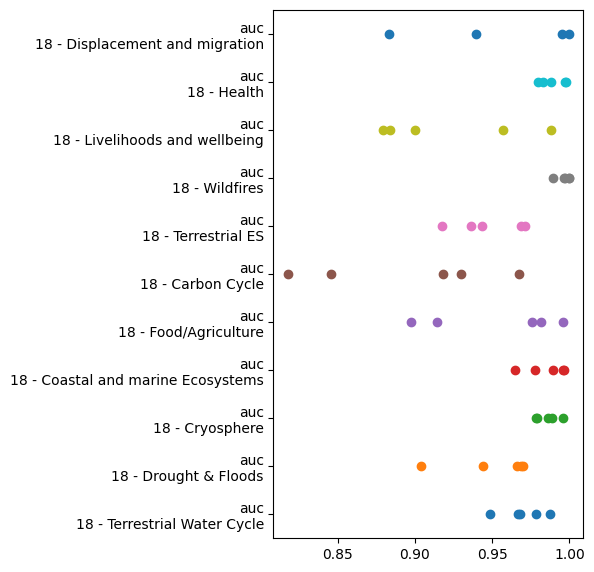

In [139]:
i = 0
fig, ax = plt.subplots(dpi=100,figsize=(4,7))
ticks = []
for x in multimodels_ar5[0]:
    if "auc\n" in x:
        data = [y for y in multimodels_ar5[0][x] if y is not None]
        print(data)
        print(x)
        ax.scatter(data, [i]*len(data))
        i+=1
        ticks.append(x)
        
ax.set_yticks(range(i))
ax.set_yticklabels(ticks)

In [138]:
print(multimodels_ar5[0][x])

[]


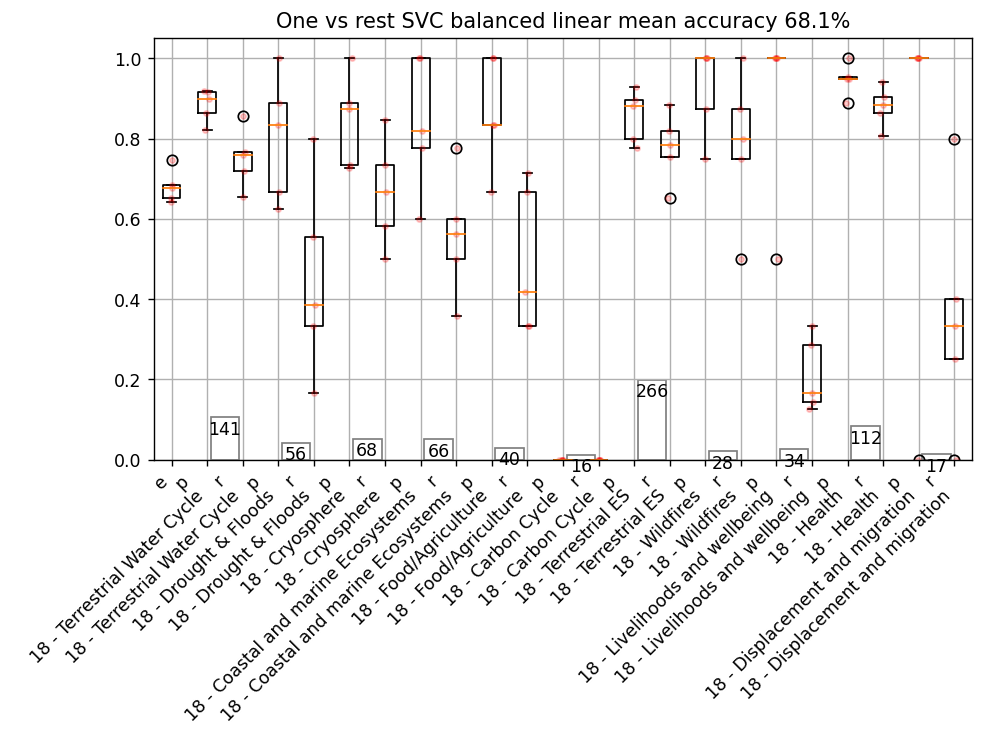

In [140]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

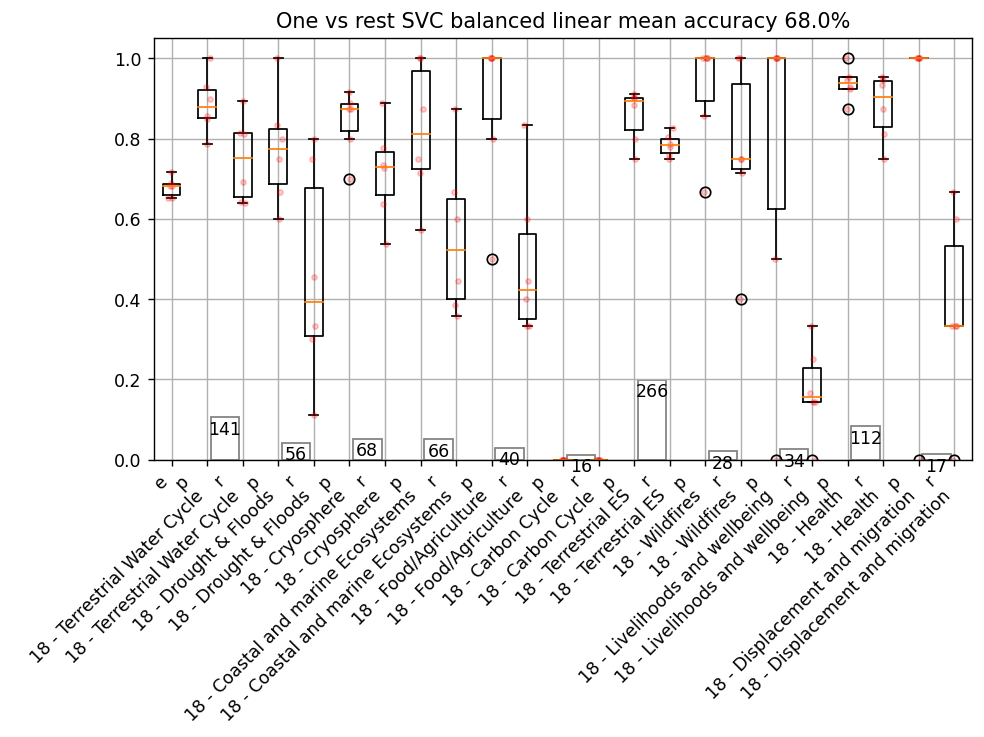

In [89]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[1]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

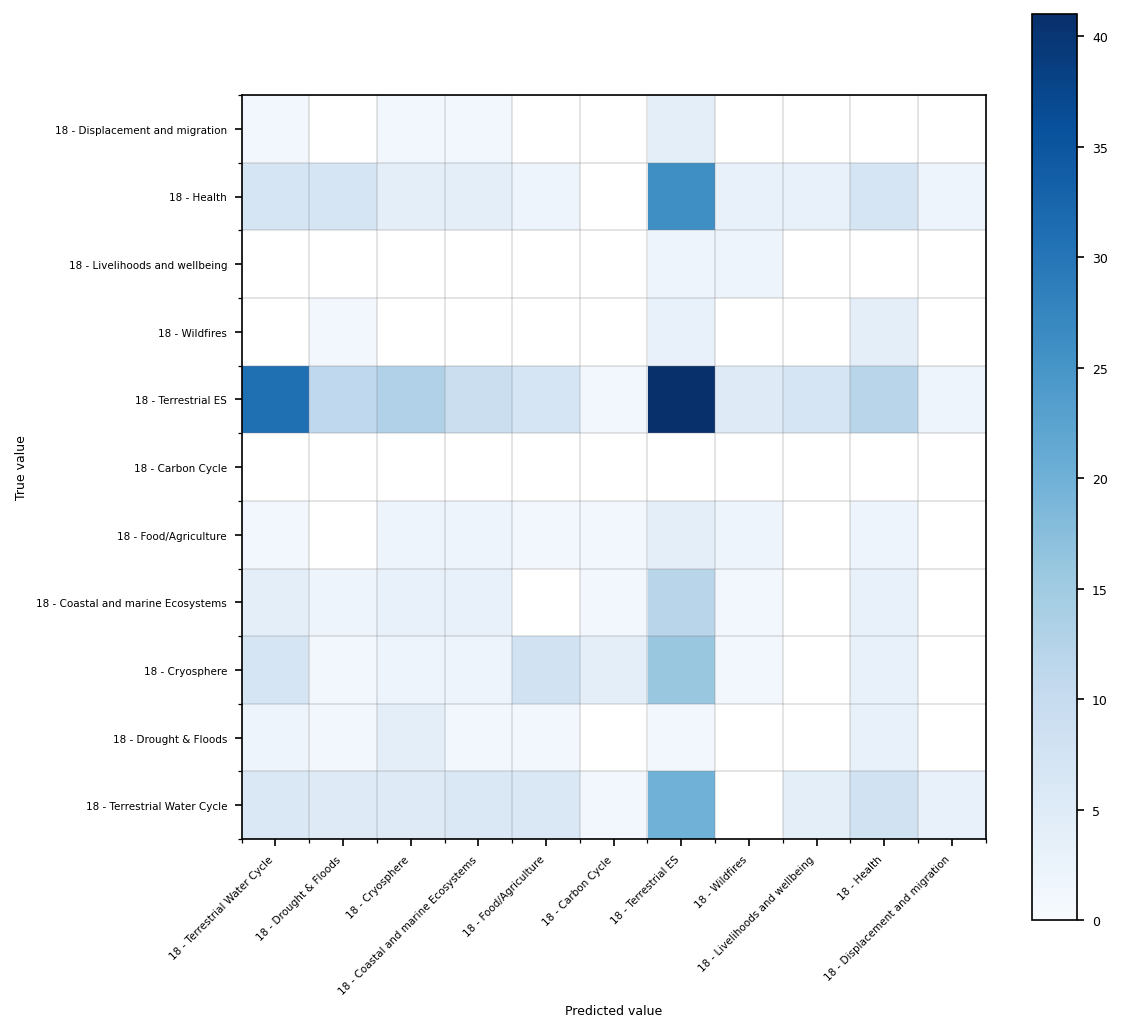

In [141]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

all_classes = specific_impacts_2
cols = [f"{c} - k_prediction_binary" for c in all_classes]
y_pred = np.array(list(df.loc[list(new_rel_index),cols].values))

   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols),len(cols)),dtype=float).T

for j, c in enumerate(all_classes):
    for k, c in enumerate(all_classes):
        n = 0
        for i in range(len(new_rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n


def plot_confusion_matrix(cm, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[j,k]
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color)

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_ylabel("True value", fontsize=6)
    ax.set_xlabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax)
    cbar.ax.tick_params(labelsize=6)
    
    if norm ==1:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    
plot_confusion_matrix(confusion_matrix)

#plt.savefig(f'../plots/prediction_models/confusion_all_classes.pdf',bbox_inches="tight")


In [144]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = df["18 - Displacement and migration"]
print(y.shape)

single_models = [
#     {
#        'title': 'One vs rest SVC balanced rbf', 
#        'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
#     },  
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=1))
    },   
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
    },   
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
dis_migrat, df = lu.cross_validate_models(X, y, single_models, new_rel_index, n_splits=3, df = df)


(2312,)
1
2
3


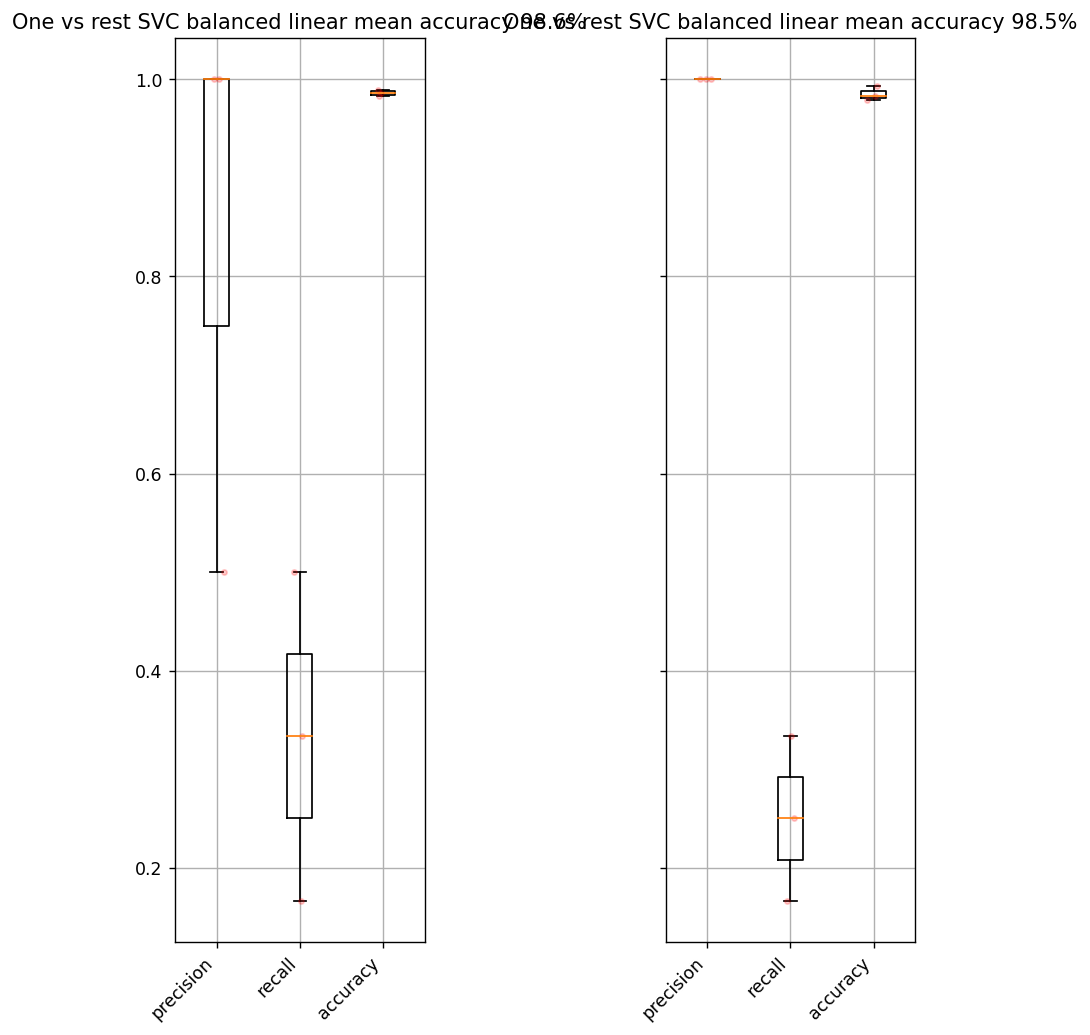

In [147]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(dis_migrat),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(dis_migrat,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()